In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [4]:
import os

BASE_PATH = r"C:\Users\maduw\Desktop\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\Dataset\voice\emotions"

print("Dataset path exists:", os.path.exists(BASE_PATH))
print("Emotion folders:", os.listdir(BASE_PATH))

Dataset path exists: True
Emotion folders: ['.ipynb_checkpoints', 'emotions.ipynb', 'OAF_Fear', 'OAF_happy', 'OAF_neutral', 'OAF_Sad', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_sad']


In [5]:
paths = []
labels = []

for emotion_folder in os.listdir(BASE_PATH):
    emotion_path = os.path.join(BASE_PATH, emotion_folder)

    if not os.path.isdir(emotion_path):
        continue

    # Extract emotion label
    label = emotion_folder.split("_")[-1].lower()

    # Keep only required emotions
    if label not in ["fear", "happy", "sad", "neutral"]:
        continue

    for file in os.listdir(emotion_path):
        if file.endswith(".wav"):
            paths.append(os.path.join(emotion_path, file))
            labels.append(label)

print("Total audio samples:", len(paths))

Total audio samples: 1600


In [6]:
paths[:5], labels[:5]

(['C:\\Users\\maduw\\Desktop\\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\\Dataset\\voice\\emotions\\OAF_Fear\\OAF_back_fear.wav',
  'C:\\Users\\maduw\\Desktop\\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\\Dataset\\voice\\emotions\\OAF_Fear\\OAF_bar_fear.wav',
  'C:\\Users\\maduw\\Desktop\\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\\Dataset\\voice\\emotions\\OAF_Fear\\OAF_base_fear.wav',
  'C:\\Users\\maduw\\Desktop\\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\\Dataset\\voice\\emotions\\OAF_Fear\\OAF_bath_fear.wav',
  'C:\\Users\\maduw\\Desktop\\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\\Dataset\\voice\\emotions\\OAF_Fear\\OAF_bean_fear.wav'],
 ['fear', 'fear', 'fear', 'fear', 'fear'])

In [7]:
df = pd.DataFrame({
    "speech": paths,
    "label": labels
})

df.head()

,speech,label
0,C:\Users\maduw\Desktop\AnxietySense-A-Multi-Mo...,fear
1,C:\Users\maduw\Desktop\AnxietySense-A-Multi-Mo...,fear
2,C:\Users\maduw\Desktop\AnxietySense-A-Multi-Mo...,fear
3,C:\Users\maduw\Desktop\AnxietySense-A-Multi-Mo...,fear
4,C:\Users\maduw\Desktop\AnxietySense-A-Multi-Mo...,fear


In [8]:
EMOTIONS = ["fear", "happy", "sad", "neutral"]
df = df[df["label"].isin(EMOTIONS)]

df["label"].value_counts()

label
fear       400
happy      400
neutral    400
sad        400
Name: count, dtype: int64

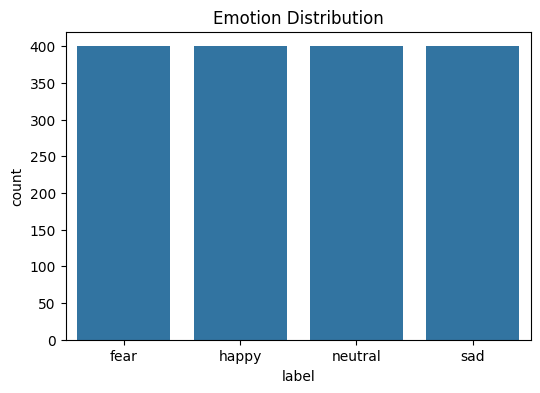

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Emotion Distribution")
plt.show()

In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    delta_mean = np.mean(delta, axis=1)

    return np.hstack((mfcc_mean, delta_mean))

In [11]:
X = np.array(df["speech"].apply(extract_features).tolist())
print("Feature shape:", X.shape)

Feature shape: (1600, 80)


In [12]:
X = np.expand_dims(X, axis=2)
print("LSTM input shape:", X.shape)

LSTM input shape: (1600, 80, 1)


In [13]:
le = LabelEncoder()
y = le.fit_transform(df["label"])
y = to_categorical(y)

print("Classes:", le.classes_)

Classes: ['fear' 'happy' 'neutral' 'sad']


In [14]:
model = Sequential([

    Bidirectional(LSTM(128, return_sequences=True), input_shape=(80,1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(len(le.classes_), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 80, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,524 (1.17 MB)

 Trainable params: 306,756 (1.17 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "emotion_lstm_best.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

In [16]:
history = model.fit(
    X, y,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4126 - loss: 1.4528

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.5906 - loss: 1.0239 - val_accuracy: 0.7969 - val_loss: 1.1305
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8793 - loss: 0.3035

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9109 - loss: 0.2421 - val_accuracy: 0.9125 - val_loss: 0.6001
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9804 - loss: 0.0906

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9820 - loss: 0.0908 - val_accuracy: 0.9750 - val_loss: 0.3189
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9736 - loss: 0.0922

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9812 - loss: 0.0695 - val_accuracy: 1.0000 - val_loss: 0.1442
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9852 - loss: 0.0483 - val_accuracy: 0.9812 - val_loss: 0.1073
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9797 - loss: 0.0535 - val_accuracy: 0.9719 - val_loss: 0.1822
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9820 - loss: 0.0606 - val_accuracy: 0.9844 - val_loss: 0.0685
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9906 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9789 - loss: 0.0795 - val_accuracy: 0.7125 - val_loss: 0.5709
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9820 - loss: 0.0607 - val_accuracy: 1.0000 - val_loss: 0.0287
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 0.9812 - va

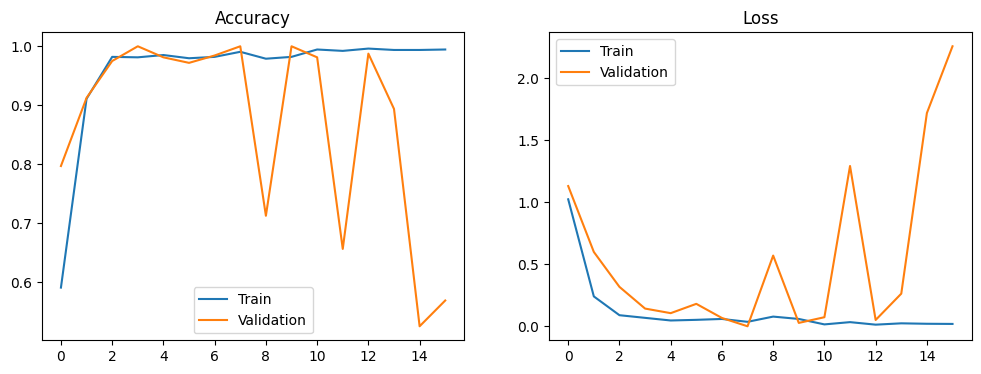

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()

In [18]:
y_pred = model.predict(X)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

print(classification_report(
    y_true,
    y_pred_cls,
    target_names=le.classes_
))

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
              precision    recall  f1-score   support

        fear       1.00      1.00      1.00       400
       happy       1.00      0.99      1.00       400
     neutral       1.00      0.99      1.00       400
         sad       0.99      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



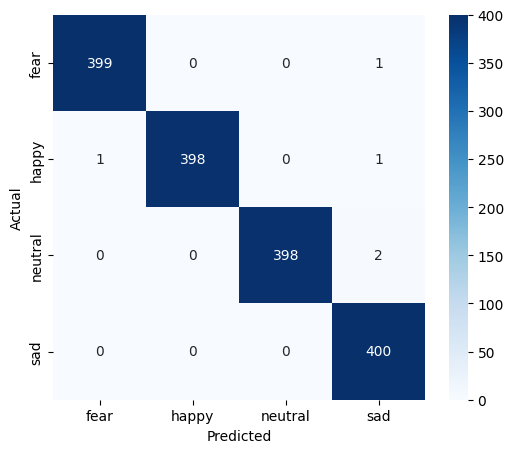

In [19]:
cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
model.save("emotion_lstm_model.h5")

import joblib
joblib.dump(le, "emotion_label_encoder.pkl")

print("Emotion model & encoder saved")

Emotion model & encoder saved


In [21]:
model.save("emotion_model.keras")
model.save("emotion_model.h5")

In [22]:
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model

In [25]:
from keras.models import load_model
import joblib

MODEL_PATH = r"C:\Users\maduw\Desktop\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\backend\voice_api\model\emotion_model.keras"
ENCODER_PATH = r"C:\Users\maduw\Desktop\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\backend\voice_api\model\emotion_label_encoder.pkl"

model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)

print("✅ Model and encoder loaded")


✅ Model and encoder loaded


In [26]:
def extract_mfcc(audio_path):
    y, sr = librosa.load(audio_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

In [28]:
TEST_AUDIO = r"C:\Users\maduw\Desktop\AnxietySense-A-Multi-Model-AI-Ecosystem-for-Life-Stage-Based-Mental-Health-Support\Dataset\voice\emotions\OAF_happy\OAF_back_happy.wav"

features = extract_mfcc(TEST_AUDIO)

print("MFCC shape:", features.shape)

MFCC shape: (40,)


In [29]:
X = np.expand_dims(features, axis=0)
X = np.expand_dims(X, axis=-1)

print("Input shape:", X.shape)

Input shape: (1, 40, 1)


In [31]:
prediction = model.predict(X)
predicted_index = np.argmax(prediction)

predicted_emotion = encoder.inverse_transform([predicted_index])[0]

print("🎯 Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
🎯 Predicted Emotion: happy


In [32]:
for i, prob in enumerate(prediction[0]):
    emotion = encoder.inverse_transform([i])[0]
    print(f"{emotion}: {prob:.2f}")


fear: 0.14
happy: 0.33
neutral: 0.22
sad: 0.31
